In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from itertools import product as pp
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.")
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


In [10]:
current_working_directory = os.getcwd()
path = os.path.dirname(current_working_directory)
year = "2019"
result_path = f"{path}/CW/data/Results/"

**OW model:**

$$I_{t+δt}-I_t=-βI_t\delta t+\frac{λσq_t}{ADV}\cdot \frac{\beta \delta t}{\beta \delta t}$$


$$I_{t+δt} = (1-β\delta t)I_t + \beta \delta t \cdot \frac{λσq_t}{ADV \cdot \beta \delta t}$$

**Bouchaud model:**

$$I_{t+δt}-I_t=-βI_t\delta t+λσ\cdot sign(q_t)\sqrt{\frac{|q_t|}{ADV}}\cdot \frac{\beta \delta t}{\beta \delta t}$$

$$I_{t+δt} = (1-β\delta t)I_t + \beta \delta t \cdot λσ\cdot sign(q_t)\sqrt{\frac{|q_t|}{ADV}} \cdot \frac{1}{\beta \delta t}$$

**Reduced form model:** 

$$I_{t+δt}-I_t=-βI_t\delta t+\frac{λσq_t}{\sqrt{ADV\cdot v_t}}\cdot \frac{\beta \delta t}{\beta \delta t}$$, where $v_{t+δt}-v_t=-βv_t\delta t+|q_t|$, so $alpha=βδt$

$$I_{t+δt} =(1-β\delta t)I_t + \beta \delta t \cdot \frac{λσq_t}{\sqrt{ADV\cdot v_t}}\cdot \frac{1}{\beta \delta t}$$

Since $βδt$ is very small, the exponential form 
$exp(−βδt)$ is often recommended over the simpler linear approximation $1−βδt$.


In [3]:
def impact_model(traded_volume_df, ADV, sigma, half_life, model_type):

    # Parameters used for ewm calculation:
    # assume lambda = 1 first
    beta = np.log(2) / half_life   # impact halflife(min) = log(2) / beta(min)
    time_unit = 10  # seconds
    decay_factor = np.exp(-beta * time_unit)
    
    # Prepare data according to model type
    if model_type == "OW":        
        pre_ewm = traded_volume_df.copy() # q_t
        pre_ewm = pre_ewm.divide(ADV, axis='rows')  # q_t / ADV
        pre_ewm = pre_ewm.multiply(sigma, axis='rows')


    elif model_type == "Bouchaud":
        pre_ewm = traded_volume_df.copy() # q_t
        sign = np.sign(pre_ewm)  # sign(q_t)
        abs_q_t = pre_ewm.abs()  # |q_t|
        pre_ewm = abs_q_t.divide(ADV, axis='rows')  # |q_t| / ADV
        pre_ewm = sign * np.sqrt(pre_ewm) #sign(q_t) * sqrt(abs(q_t)/ADV)     
        pre_ewm = pre_ewm.multiply(sigma, axis='rows') 

    elif model_type == "Reduced":
        abs_q_t = traded_volume_df.abs() # |q_t|
        v_t = abs_q_t.T.ewm(alpha=1 - decay_factor, adjust=False).mean().T #  y_t=(1-\alpha)y_{t-1}+\alpha x_t
        denominator = np.sqrt(v_t.copy().multiply(ADV, axis='rows'))   # sqrt(ADV * v_t)  
        pre_ewm = traded_volume_df.divide(denominator + 1e-10) # use 1e-10 to avoid division by zero
        pre_ewm = pre_ewm.multiply(sigma, axis='rows')
    
    else:
        raise ValueError("Unsupported model type")

    # Calculate cumulative impact I_t
    pre_ewm.iloc[:, 1:] /= (1 - decay_factor)   
    I_t = pre_ewm.T.ewm(alpha=1 - decay_factor, adjust=False).mean().T

    return I_t


## **Linear Regression**
$y=\alpha+\beta x$, so
$$\beta=\frac{\sum_{i=1}^n(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^n(x_i-\bar{x})^2}$$


Compute:
$$\Delta_hP_t=\frac{P_{t+h}-P_t}{P_t};\quad\Delta_hI(\beta,1)=I_{t+h}(\beta,1)-I_t(\beta,1)$$

Then fitting
$$\Delta_hP_t=\lambda\Delta_hI_t(\beta,1)+\epsilon $$
to get $\lambda$( is $\beta$ in $y=\alpha+\beta x$)

In [4]:
def impact_regression_statistics(impact, px_df, h_rows):
    # for each h = 1, 15, 60 compute the impact changes and the price change pct
    impact_changes = impact.diff(h_rows, axis="columns").T.unstack().reset_index().rename({"level_2": "time", 0: "x"}, axis="columns").copy()
    pct_return = px_df.T.pct_change(h_rows).unstack().reset_index().rename({"level_2": "time", 0: "y"}, axis="columns").copy()
    pct_return = pct_return.copy()
    impact_changes = impact_changes.loc[impact_changes["time"] >= "10:00:00"].dropna(axis=0).copy()
    pct_return = pct_return.loc[pct_return["time"] >= "10:00:00"].dropna(axis=0).copy()
    # print(impact_changes.columns) # ['stock', 'date', 'time', 'x']
    # print(pct_return.columns)  # ['stock', 'date', 'time', 'y']

    # ensure the index is the same
    common_index = impact_changes.index.intersection(pct_return.index)
    impact_changes = impact_changes.loc[common_index]
    pct_return = pct_return.loc[common_index]

    # merge the two dataframes
    reg_info_df = impact_changes.copy()
    reg_info_df["y"] = pct_return["y"]

    # calculate the necessary columns
    reg_info_df["xy"] = reg_info_df["x"] * reg_info_df["y"]
    reg_info_df["x2"] = reg_info_df["x"] * reg_info_df["x"]
    reg_info_df["y2"] = reg_info_df["y"] * reg_info_df["y"]
    reg_info_df["count"] = 1

    return reg_info_df # ['stock', 'date', 'time', 'x', 'y', 'xy', 'x2', 'y2', 'count']


In [12]:
windows = 20
filename = f"inter_results_stock_info_df_{year}all.csv" # ['index', 'stock', 'date', px_vol', 'volume']
stock_info_df = pd.read_csv(result_path+filename)
stacked_info = stock_info_df.pivot(index="date", columns="stock", values=["px_vol", "volume"]).rolling(windows).mean().shift(1)
rolling_stats_df = pd.DataFrame({
    "sigma": stacked_info["px_vol"].unstack(), # sigma
    "ADV": stacked_info["volume"].unstack(), # ADV
}).reset_index()

In [13]:
rolling_stats_df.head()

,stock,date,sigma,ADV
0,A,2019-01-02,NaN,NaN
1,A,2019-01-03,NaN,NaN
2,A,2019-01-04,NaN,NaN
3,A,2019-01-07,NaN,NaN
4,A,2019-01-08,NaN,NaN


# **Impact model fitting**

In [13]:
horizon_list = [1,15,60]
beta_list = [1,15,60,120]
model_list = ["OW","Reduced","Bouchaud"]
for model in model_list:
    print(f"Model: {model}")
    for h in tqdm(horizon_list):          
        for beta in tqdm(beta_list):  # i = beta (mins)
            all_monthly_dfs = []
            for month_int in range(2,13):
                month = f'{month_int:02d}'
                half_life = beta * 60  # half-life in seconds
                filename_volume = f"inter_results_volume_{year}{month}.csv"
                filename_px = f"inter_results_px_{year}{month}.csv"
                traded_volume_df = pd.read_csv(result_path+filename_volume).set_index(["stock","date"])           
                px_df = pd.read_csv(result_path+filename_px).set_index(["stock","date"])    
                rolling_factor = rolling_stats_df.set_index(["stock", "date"]).loc[traded_volume_df.index] 
                ADV = rolling_factor["ADV"]
                sigma = rolling_factor["sigma"]
                impact = impact_model(traded_volume_df, ADV, sigma, half_life, model_type=model)
                horizon_rows = h * 60 // 10  # h in minutes, horizon_rows get the number of rows to shift
                impact_reg_stat = impact_regression_statistics(impact, px_df, horizon_rows)
                daily_stock_reg_info_df = impact_reg_stat.groupby(["stock","date"])[["x", "y", "xy", "x2", "y2", "count"]].sum().reset_index()
                daily_stock_reg_info_df["date"] = pd.to_datetime(daily_stock_reg_info_df['date'])
                all_monthly_dfs.append(daily_stock_reg_info_df)
            daily_reg_info_df_all = pd.concat(all_monthly_dfs, ignore_index=True)
            filename = f"{model}_reg_info_{year}_horizon{h}_beta{beta}mins.csv"
            daily_reg_info_df_all.to_csv(result_path+filename)

Model: OW


100%|██████████| 3/3 [07:37<00:00, 152.39s/it]


Model: Reduced


100%|██████████| 3/3 [07:44<00:00, 154.75s/it]


Model: Bouchaud


100%|██████████| 3/3 [07:37<00:00, 152.42s/it]


# **Performance of models across various horizons and impact halflices $\log(2)/\beta$**

$$\beta=\frac{\sum_{i=1}^n(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^n(x_i-\bar{x})^2}$$  $$=\frac{Cov(x,y)}{Var(x)}$$  $$=\frac{\text{sum of }xy-\frac{(\text{sum of }x)(\text{sum of }y)}n}{\text{sum of }x^2-\frac{(\text{sum of }x)^2}n}$$

$$\alpha=\bar{y}-\beta\bar{x}$$

#### SST (Total Sum of Squares): 
$$SST=\sum_{i=1}^n(y_i-\bar{y})^2$$  $$=\sum_{i=1}^n y_i^2-\frac{(\sum_{i=1}^n y_i)^2}{n}$$

#### RSS (Residual Sum of Squares):
$$RSS=\sum_{i=1}^n(y - \hat{y_i})^2$$  $$=\sum_{i=1}^n(\alpha+\beta x_i-{y})^2$$ $$=n\alpha^2+2\alpha\beta\sum_{i=1}^nx_i-2\alpha \sum_{i=1}^ny_i+\beta^2\sum_{i=1}^nx_i^2-2\beta\sum_{i=1}^nx_iy_i+\sum_{i=1}^n(y_i^2)$$

#### $R^2$:
$$R^2=1-\frac{RSS}{SST}$$   

In [14]:
def compute_regression_result(daily_stock_reg_info_df, in_sample_month):
    daily_stock_reg_info_df['date'] = pd.to_datetime(daily_stock_reg_info_df['date'])
    in_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month]
    out_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month + 1]

    # for each stock, calculate the sum of x, y, xy, x^2, y^2, and count
    in_sample_result_df = in_sample_df.groupby("stock")[["xy", "x2", "y2", "x", "y", "count"]].sum()
    out_sample_result_df = out_sample_df.groupby("stock")[["xy", "x2", "y2", "x", "y", "count"]].sum()

    in_sample_result_df.columns = "IS_" + in_sample_result_df.columns
    out_sample_result_df.columns = "OOS_" + out_sample_result_df.columns

    result_df = pd.merge(in_sample_result_df, out_sample_result_df, left_index=True, right_index=True, how="inner")

    Cov_x_y = result_df["IS_xy"] - result_df["IS_x"] * result_df["IS_y"] / result_df["IS_count"]
    Var_x = result_df["IS_x2"] - result_df["IS_x"] ** 2 / result_df["IS_count"]
    result_df["lambda_estimate"] = Cov_x_y / Var_x
    result_df["epsilon_estimate"] = result_df["IS_y"] / result_df["IS_count"] - result_df["lambda_estimate"] * result_df["IS_x"] / result_df["IS_count"]
    result_df["IS_SST"] = result_df["IS_y2"] - result_df["IS_y"] ** 2 / result_df["IS_count"]
    result_df["IS_RSS"] = (result_df["IS_count"] * result_df["epsilon_estimate"] ** 2 +
                           2 * result_df["epsilon_estimate"] * result_df["lambda_estimate"] * result_df["IS_x"] -
                           2 * result_df["epsilon_estimate"] * result_df["IS_y"] +
                           result_df["lambda_estimate"] ** 2 * result_df["IS_x2"] -
                           2 * result_df["lambda_estimate"] * result_df["IS_xy"] +
                           result_df["IS_y2"])
    result_df["IS_R2"] = 1 - result_df["IS_RSS"] / result_df["IS_SST"]

    result_df["OOS_SST"] = result_df["OOS_y2"] - result_df["OOS_y"] ** 2 / result_df["OOS_count"]
    result_df["OOS_RSS"] = (result_df["OOS_count"] * result_df["epsilon_estimate"] ** 2 +
                            2 * result_df["epsilon_estimate"] * result_df["lambda_estimate"] * result_df["OOS_x"] -
                            2 * result_df["epsilon_estimate"] * result_df["OOS_y"] +
                            result_df["lambda_estimate"] ** 2 * result_df["OOS_x2"] -
                            2 * result_df["lambda_estimate"] * result_df["OOS_xy"] +
                            result_df["OOS_y2"])
    result_df["OOS_R2"] = 1 - result_df["OOS_RSS"] / result_df["OOS_SST"]

    return result_df

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


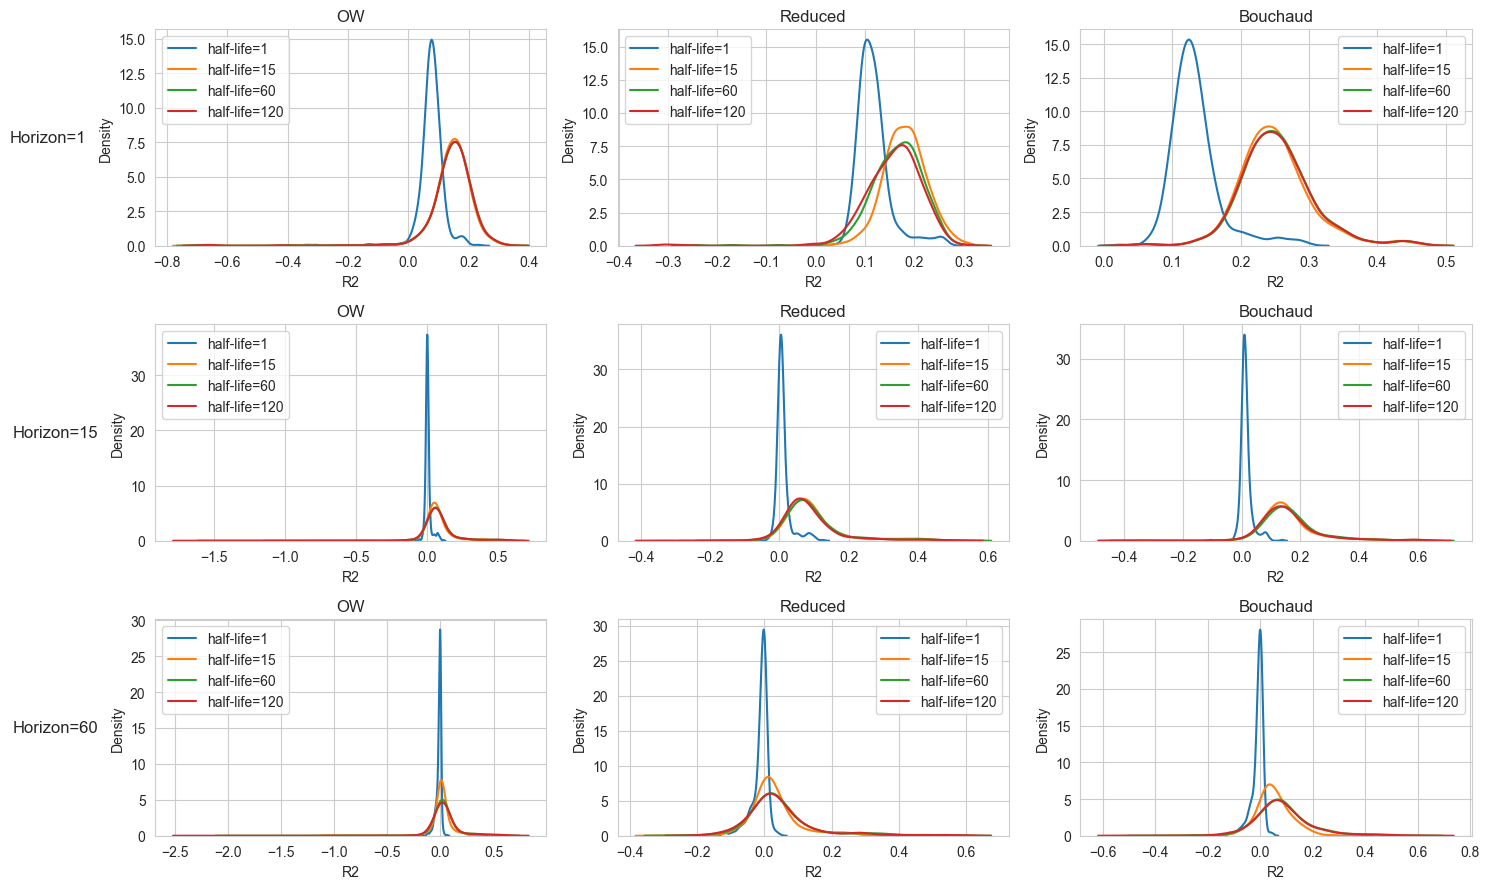

In [15]:
# Plot distribution of  OOS R2 across different choices of h(rows) and models(columns) for different betas(half-life in minutes)
def compute_oos_r2(model, year, horizon, beta, month, result_path):
    filename = f"{model}_reg_info_{year}_horizon{horizon}_beta{beta}mins.csv"
    df = pd.read_csv(result_path + filename)
    # Remove inf values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    result = compute_regression_result(df, month)
    return result["OOS_R2"].values

def prepare_plot_data(horizon_list, beta_list, model_list, year, result_path):
    plot_data = {model: {} for model in model_list}
    for horizon, beta in pp(horizon_list, beta_list): 
        monthly_r2 = {model: [] for model in model_list}
        for month in range(2, 12):
            for model in model_list:
                monthly_r2[model].extend(compute_oos_r2(model, year, horizon, beta, month, result_path))
        for model, data in monthly_r2.items():
            clean_data = np.array(data)
            clean_data = clean_data[np.isfinite(clean_data)]  # Remove inf values
            plot_data[model][(horizon, beta)] = clean_data
    return plot_data

def plot_density_models(plot_data):
    horizons = sorted(set(horizon for model_data in plot_data.values() for horizon, beta in model_data.keys()))
    betas = sorted(set(beta for model_data in plot_data.values() for horizon, beta in model_data.keys()))
    fig, axes = plt.subplots(len(horizons), len(plot_data), figsize=(15, 3* len(horizons)))

    for row, horizon in enumerate(horizons):
        for col, (model_name, model_data) in enumerate(plot_data.items()):
            for beta in betas:
                if (horizon, beta) in model_data:
                    sns.kdeplot(model_data[(horizon, beta)], ax=axes[row, col], label=f'half-life={beta}')
            if col == 0:
                axes[row, col].annotate(f'Horizon={horizon}', xy=(0, 0.5), xytext=(-axes[row, col].yaxis.labelpad - 5, 0),
                                        xycoords=axes[row, col].yaxis.label, textcoords='offset points',
                                        size='large', ha='right', va='center', rotation=0)
            axes[row, col].set_title(f'{model_name}')
            axes[row, col].set_xlabel('R2')
            axes[row, col].set_ylabel('Density')
            axes[row, col].legend()

    plt.tight_layout()
    fig.savefig(f"{current_working_directory}/R2_density_plot.eps", format='eps')
    plt.show()


horizon_list = [1, 15, 60]
beta_list = [1, 15, 60, 120]
model_list = ["OW", "Reduced", "Bouchaud"]
plot_data = prepare_plot_data(horizon_list, beta_list, model_list, year, result_path)
plot_density_models(plot_data)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


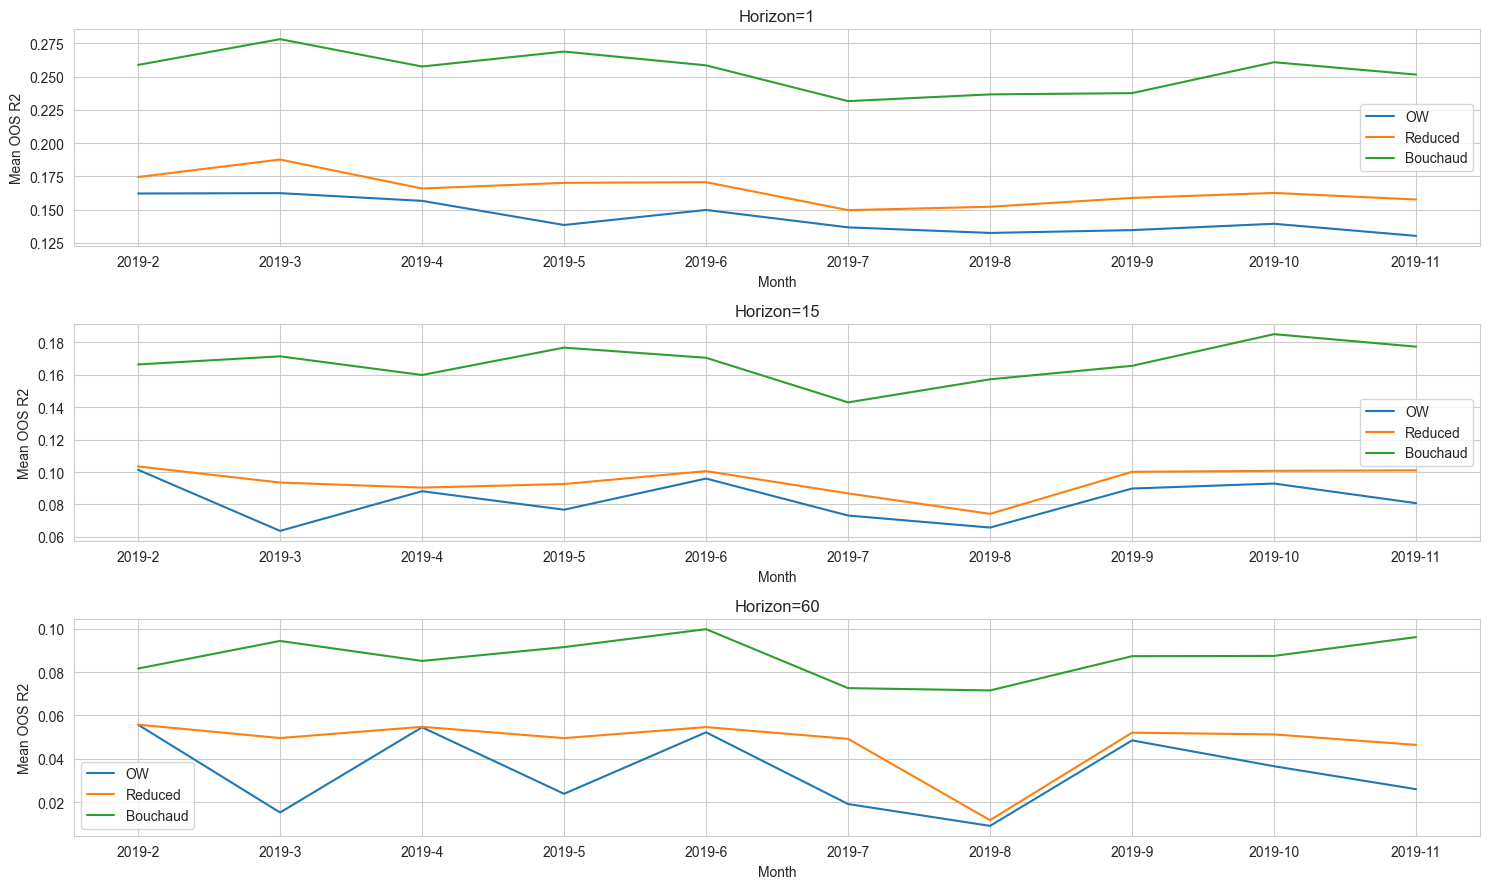

In [16]:
# Plot average model oos R2 across months and h for log(2)/beta = 60 mins
def compute_mean_r2(model, horizon, result_path):
    filename = f"{model}_reg_info_2019_horizon{horizon}_beta{60}mins.csv"
    df = pd.read_csv(result_path + filename)
    mean_r2 = [np.mean(compute_regression_result(df, month)["OOS_R2"].values) for month in range(2, 12)]
    return mean_r2

def prepare_mean_plot(horizon_list, model_list, result_path):
    mean_r2_plot = {model: {} for model in model_list}
    for horizon in horizon_list:
        for model in model_list:
            mean_r2_plot[model][horizon] = compute_mean_r2(model, horizon, result_path)
    return mean_r2_plot

def plot_mean_r2_for_horizons(mean_r2_data):
    horizons = sorted(set(h for model_data in mean_r2_data.values() for h in model_data.keys()))
    month_labels = [f'2019-{i}' for i in range(2, 12)]

    fig, axes = plt.subplots(len(horizons), 1, figsize=(15, 3* len(horizons)))

    for idx, horizon in enumerate(horizons):
        ax = axes[idx] if len(horizons) > 1 else axes  # Handle single subplot case
        for model_name, model_data in mean_r2_data.items():
            if horizon in model_data:
                ax.plot(month_labels, model_data[horizon], label=model_name)

        ax.set_title(f'Horizon={horizon}')
        ax.set_xlabel('Month')
        ax.set_ylabel('Mean OOS R2')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    fig.savefig(f"{current_working_directory}/average_oos_r2.eps", format='eps')
    plt.show()

horizon_list = [1, 15, 60]
model_list = ["OW", "Reduced", "Bouchaud"]

mean_r2_plot = prepare_mean_plot(horizon_list, model_list, result_path)
plot_mean_r2_for_horizons(mean_r2_plot)

From the plot above, we can see that a smaller horizon has a higher $R^2$ because a shorter time interval can better capture the relationship between impacts at each time point. In contrast, for larger horizons cases, the impact may disappear by the next time spot.

In [50]:
# compute mean IS R2, mean OOS R2 and Tstat
def compute_statistics(model, year, horizon, result_path):
    filename = f"{model}_reg_info_{year}_horizon{horizon}_beta{60}mins.csv"
    df = pd.read_csv(result_path + filename)
    OOS_R2 = np.array([])
    IS_R2 = np.array([])
    lambda_estimates = np.array([])
    for month in range(2, 12):
        result = compute_regression_result(df, month)
        OOS_R2 = np.append(OOS_R2, result['OOS_R2'].values)
        IS_R2 = np.append(IS_R2, result['IS_R2'].values)
        lambda_estimates = np.append(lambda_estimates, result['lambda_estimate'].values)
    return np.mean(IS_R2), np.mean(OOS_R2), np.mean(lambda_estimates) / np.std(lambda_estimates) 

def prepare_statistics(horizon_list, model_list, year, result_path):
    statistics = {}
    for horizon in horizon_list:
        for model in model_list:
            IS_R2, OOS_R2, t_stats = compute_statistics(model, year, horizon, result_path)
            statistics[(model, horizon)] = [IS_R2, OOS_R2, t_stats]
    return statistics

def format_statistics(statistics):
    stats_df = pd.DataFrame.from_dict(statistics, orient='index', columns=['IS R^2', 'OS R^2', 't-stats'])
    stats_df.index = pd.MultiIndex.from_tuples(stats_df.index, names=["Model Name", "Horizon"])
    stats_df[['IS R^2', 'OS R^2']] *= 100
    stats_df = stats_df.round(2)
    stats_df[['IS R^2', 'OS R^2']] = stats_df[['IS R^2', 'OS R^2']].applymap(lambda x: f'{x}%')
    return stats_df

#### IS $R^2$: 
How well the model fits the data in-sample. A high value indicates that the model explains a large portion of the variance in the data. Poor IS $R^2$ may indicate that the model is not capturing the underlying dynamics of the data.

#### OOS $R^2$:
How well the model generalizes to new data. A high value indicates that the model is able to predict unseen data well. Poor OOS $R^2$ may indicate that the model is overfitting the data.

In [17]:
horizon_list = [1, 15, 60]
model_list = ["OW", "Reduced", "Bouchaud"]

statistics = prepare_statistics(horizon_list, model_list, year, result_path)
formatted_stats = format_statistics(statistics)
formatted_stats

C:\Users\zkr_l\AppData\Local\Temp\ipykernel_25248\2231482412.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats_df[['IS R^2', 'OS R^2']] = stats_df[['IS R^2', 'OS R^2']].applymap(lambda x: f'{x}%')


,,IS R^2,OS R^2,t-stats
Model Name,Horizon,,,
OW,1,16.62%,14.43%,3.87
Reduced,1,17.8%,16.5%,4.01
Bouchaud,1,26.18%,25.4%,7.11
OW,15,10.96%,8.28%,2.27
Reduced,15,11.15%,9.43%,1.98
Bouchaud,15,18.27%,16.73%,3.60
OW,60,8.7%,3.41%,1.49
Reduced,60,8.51%,4.75%,1.26
Bouchaud,60,12.53%,8.68%,2.20


## 2.3 **Backtest engine**

In [44]:
# if back=True, the return is S since S = P - I(Q)
def impact_resultant_prices(model, trades, prices, decay_factor, estimated_lambda, sigma, ADV, back=False):
    trades_copy = trades.copy()
    if back:
        trades_copy *= -1

    if model == "OW":
        trades_copy = trades_copy
    elif model == "Bouchaud":
        trades_copy = np.sign(trades_copy) * np.sqrt(np.abs(trades_copy))
    elif model == "Reduced":
        trades_copy = np.abs(trades_copy)       
    else:
        raise ValueError("Unsupported model")

    # Adjust trades for decay
    trades_copy[1:] /= (1 - decay_factor)

    # Scale trades by price volatility and ADV
    if model == "OW":
        trades_copy *= sigma * estimated_lambda/ ADV
    elif model == "Bouchaud":
        trades_copy *= sigma * estimated_lambda/ np.sqrt(ADV)
    elif model == "Reduced":
        v_t = trades_copy.ewm(alpha=1 - decay_factor, adjust=False).mean()
        trades_copy *= sigma * estimated_lambda/ np.sqrt(ADV * v_t + 1e-10)  # use 1e-10 to avoid division by zero

    Impact = trades_copy.ewm(alpha=1-decay_factor, adjust=False).mean()

    Returns = prices / prices.iloc[0] - 1
    Returns += Impact
    # Return resultant prices
    return prices.iloc[0] * (Returns + 1)

In [45]:
ssdf = rolling_stats_df[(rolling_stats_df["stock"] == "AAPL") & (rolling_stats_df["date"] == "2019-10-04")]
sigma_value = ssdf["sigma"].values
ADV_value = ssdf["ADV"].values
filename_px = f"inter_results_px_df_{2019}{10}.csv"
filename_volume = f"inter_results_trade_volume_df_{2019}{10}.csv"
px_df = pd.read_csv(result_path+filename_px).set_index(["stock","date"])
traded_volume_df = pd.read_csv(result_path+filename_volume).set_index(["stock","date"])
prices = px_df.loc[("AAPL","2019-10-04")]
trades = traded_volume_df.loc[("AAPL","2019-10-04")]
decay_factor = np.exp(- np.log(2) / 3600 * 10) # use halflife = 60 mins = 3600 seconds, decay = exp(-beta * time_unit) and beta = log(2) / halflife
filename = f"OW_reg_info_2019_horizon1_beta{60}mins.csv"
df = pd.read_csv(result_path + filename)
result = compute_regression_result(df, 10)
estimated_lambda = result["lambda_estimate"]['AAPL']
print(estimated_lambda)


344.8227097062752


In [46]:
print(trades)

09:30:00     9593
09:30:10    -8139
09:30:20    -3959
09:30:30     4608
09:30:40     3199
            ...  
15:59:20    19919
15:59:30   -12752
15:59:40   -26494
15:59:50    47603
16:00:00        0
Name: (AAPL, 2019-10-04), Length: 2341, dtype: int64


In [47]:
S = impact_resultant_prices("OW", trades, prices, decay_factor, estimated_lambda, sigma_value, ADV_value, back=True)

C:\Users\zkr_l\AppData\Local\Temp\ipykernel_25248\532474557.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4231224.98351478   2058166.81530102  -2395562.68878684 ...
  13773445.71977399 -24747389.46925346         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trades_copy[1:] /= (1 - decay_factor)


In [48]:
# sub S into the function again to get the resultant prices
resultant_prices = impact_resultant_prices("OW", trades, S, decay_factor, estimated_lambda, sigma_value, ADV_value,back=False)


C:\Users\zkr_l\AppData\Local\Temp\ipykernel_25248\532474557.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ -4231224.98351478  -2058166.81530102   2395562.68878684 ...
 -13773445.71977399  24747389.46925346         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trades_copy[1:] /= (1 - decay_factor)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


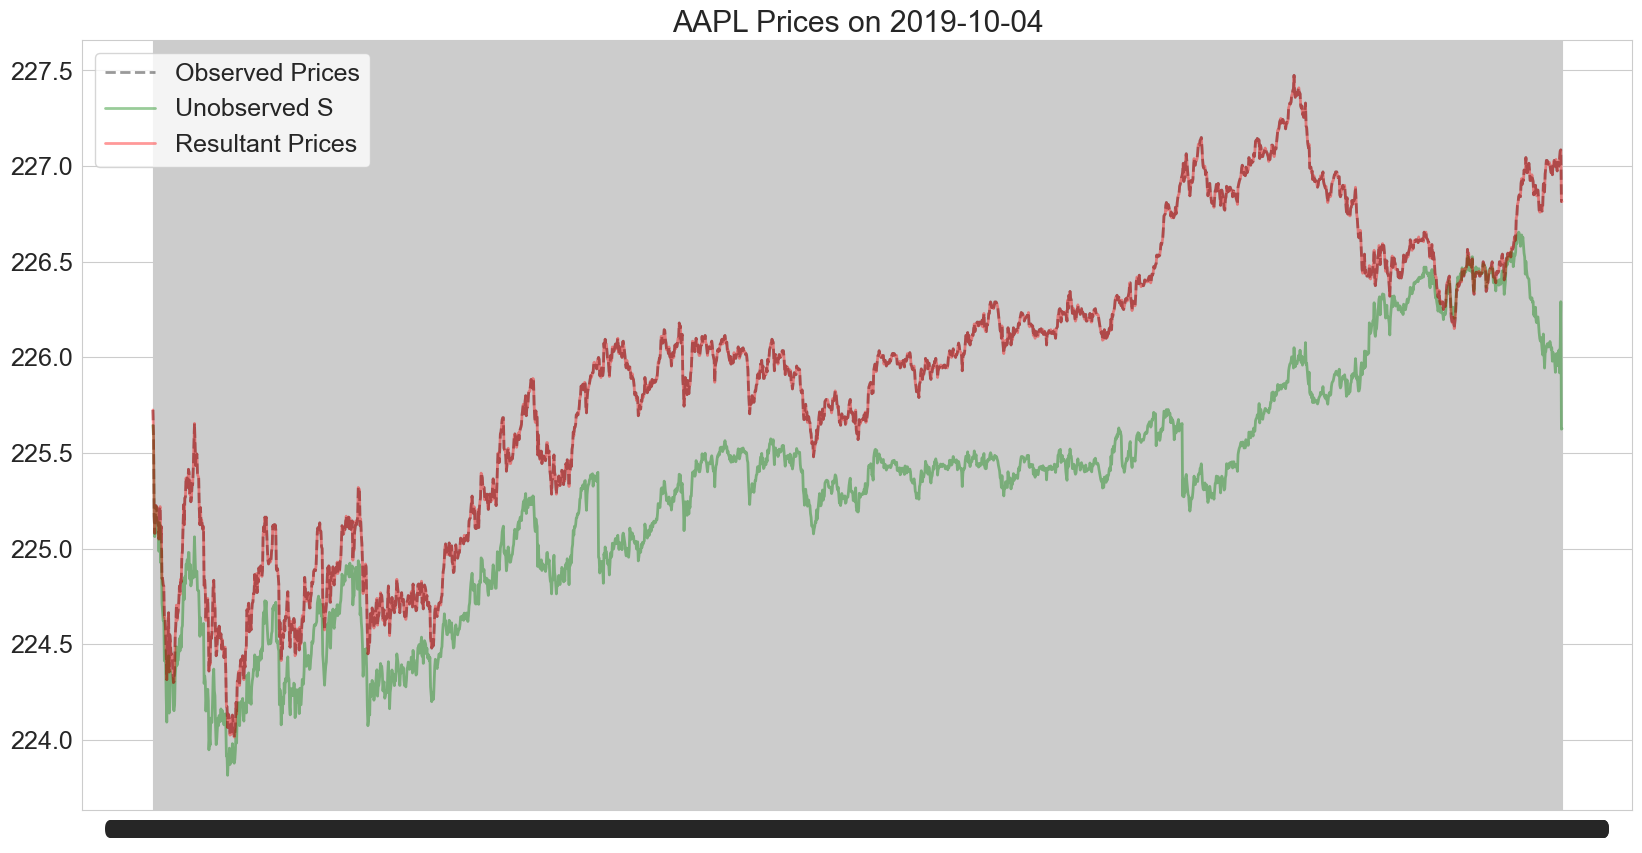

In [49]:
# plot S and resultant prices
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20, 10))
plt.plot(prices, label="Observed Prices", alpha=0.4, color='black',linewidth=2, linestyle='dashed')
plt.plot(S, label="Unobserved S", alpha=0.4, color='green',linewidth=2)
plt.plot(resultant_prices, label="Resultant Prices", alpha=0.4, color='red',linewidth=2)
plt.legend()
plt.title("AAPL Prices on 2019-10-04")
plt.savefig(f"{current_working_directory}/backtest_prices.eps", format='eps')
plt.show()

In [25]:
# check whether prices and resultant prices are very close
print(prices)

09:30:00    225.725
09:30:10    225.590
09:30:20    225.170
09:30:30    225.080
09:30:40    225.165
             ...   
15:59:20    227.045
15:59:30    227.080
15:59:40    227.085
15:59:50    226.815
16:00:00    226.815
Name: (AAPL, 2019-10-04), Length: 2341, dtype: float64


In [26]:
print(resultant_prices)

09:30:00    225.724972
09:30:10    225.589996
09:30:20    225.170008
09:30:30    225.079994
09:30:40    225.164984
               ...    
15:59:20    227.044600
15:59:30    227.079639
15:59:40    227.084718
15:59:50    226.814577
16:00:00    226.814578
Name: (AAPL, 2019-10-04), Length: 2341, dtype: float64


In [28]:
# reudced model
ssdf = rolling_stats_df[(rolling_stats_df["stock"] == "AAPL") & (rolling_stats_df["date"] == "2019-10-04")]
sigma_value = ssdf["sigma"].values
ADV_value = ssdf["ADV"].values
filename_px = f"inter_results_px_df_{2019}{10}.csv"
filename_volume = f"inter_results_trade_volume_df_{2019}{10}.csv"
px_df = pd.read_csv(result_path+filename_px).set_index(["stock","date"])
traded_volume_df = pd.read_csv(result_path+filename_volume).set_index(["stock","date"])
prices = px_df.loc[("AAPL","2019-10-04")]
trades = traded_volume_df.loc[("AAPL","2019-10-04")]
decay_factor = np.exp(-np.log(2) / 3600 * 10) # use halflife = 60 mins = 3600 seconds, decay = exp(-beta * time_unit) and beta = log(2) / halflife
filename = f"Reduced_reg_info_2019_horizon1_beta{60}mins.csv"
df = pd.read_csv(result_path + filename)
result = compute_regression_result(df, 10)
estimated_lambda = result["lambda_estimate"]['AAPL']
print(estimated_lambda)

9.28739968701019


In [29]:
S_reduced = impact_resultant_prices("Reduced", trades, prices, decay_factor, estimated_lambda, sigma_value, ADV_value, back=True)

C:\Users\zkr_l\AppData\Local\Temp\ipykernel_25248\35860221.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4231224.98351478   2058166.81530102  -2395562.68878684 ...
  13773445.71977399 -24747389.46925346         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trades_copy[1:] /= (1 - decay_factor)


In [30]:
# sub S into the function again to get the resultant prices
resultant_prices_reduced = impact_resultant_prices("Reduced", trades, S_reduced, decay_factor, estimated_lambda, sigma_value, ADV_value,back=False)

C:\Users\zkr_l\AppData\Local\Temp\ipykernel_25248\35860221.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ -4231224.98351478  -2058166.81530102   2395562.68878684 ...
 -13773445.71977399  24747389.46925346         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trades_copy[1:] /= (1 - decay_factor)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


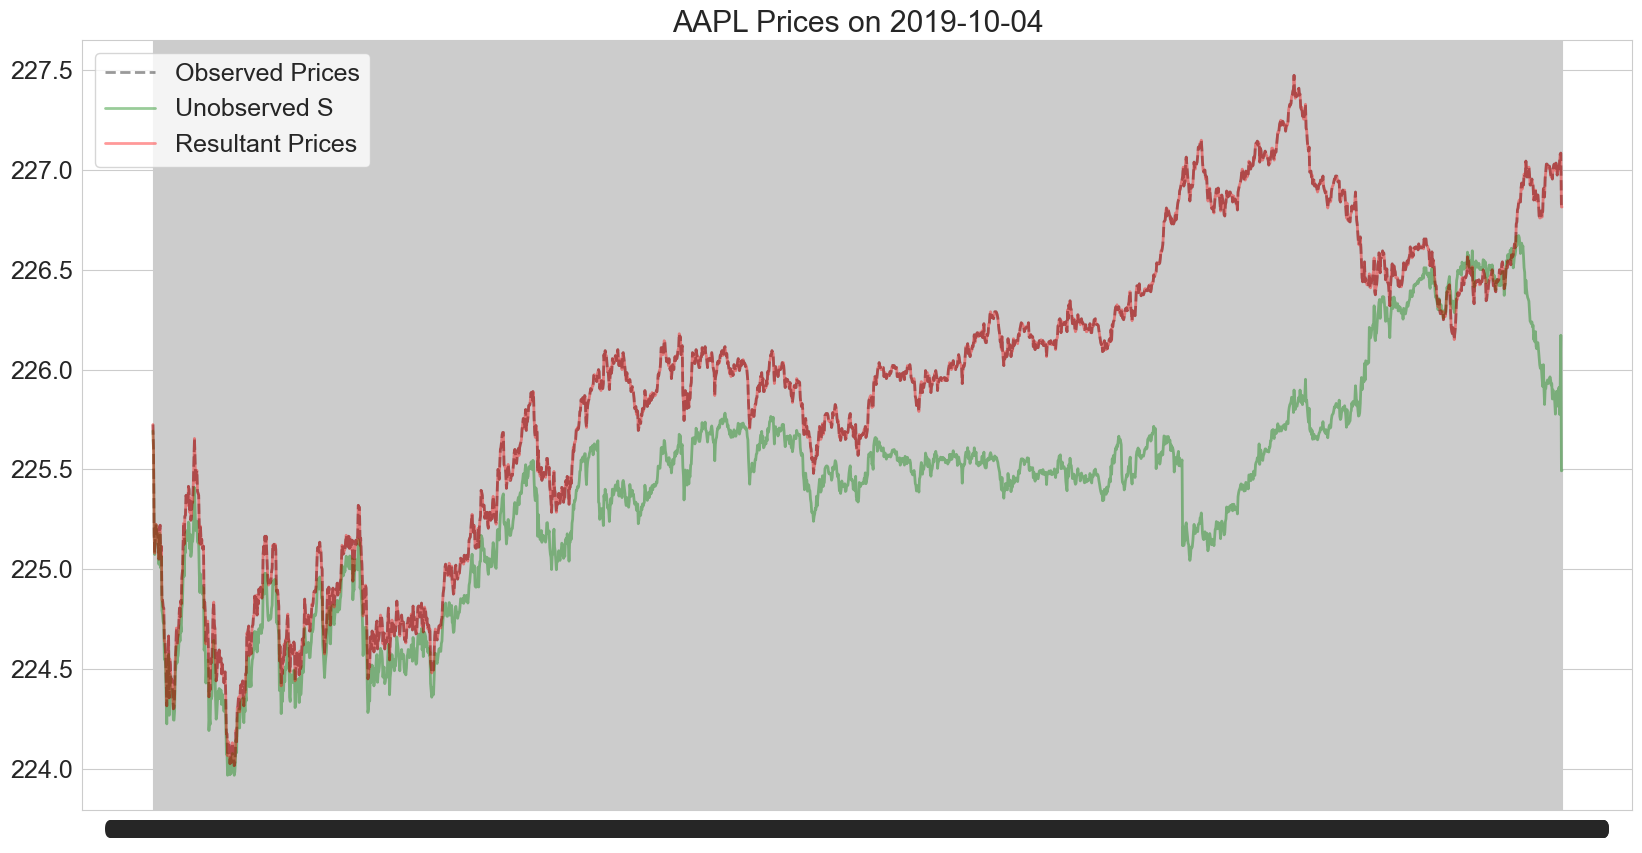

In [37]:
# plot S and resultant prices
plt.figure(figsize=(20, 10))
plt.plot(prices, label="Observed Prices", alpha=0.4, color='black',linewidth=2, linestyle='dashed')
plt.plot(S_reduced, label="Unobserved S", alpha=0.4, color='green',linewidth=2)
plt.plot(resultant_prices_reduced, label="Resultant Prices", alpha=0.4, color='red',linewidth=2)
plt.legend()
plt.title("AAPL Prices on 2019-10-04")
plt.savefig(f"{current_working_directory}/backtest_prices_reduced.eps", format='eps')
plt.show()